# Project 2: Building a Student Intervention System

### Supervised Learning

## Exploring the Data

In [36]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as pl
%matplotlib inline

In [11]:
# Read student data
student_data = pd.read_csv("student-data.csv")

student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [6]:
n_students = student_data.shape[0]
n_features = student_data.shape[1] - 1
n_passed = (student_data['passed'] == 'yes').sum()
n_failed = (student_data['passed'] == 'no').sum()
grad_rate = float(n_passed) / (n_passed + n_failed) * 100

print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

print "Of 10000 students, we can save up to {}".format((1 - .6709) * .803 * 10000)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%
Of 10000 students, we can save up to 2642.673


## Preparing the Data

In [10]:
# column names
feature_cols = list(student_data.columns[:-1])
target_col = student_data.columns[-1]
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

# feature and target data
X_all = student_data[feature_cols]
y_all = student_data[target_col]
print "\nFeature values:-"

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-


### Preprocess feature columns

Create dummy columns and to convert most data into binary inputs

In [12]:
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)

print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

In [35]:
from sklearn.cross_validation import train_test_split

num_all = student_data.shape[0]
# Use about 75% of the data
# rounded, so we can use 100, 200, and 300 later
num_train = 300
num_test = num_all - num_train

# randomize data (random_state=12) and split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=12)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

Training set: 300 samples
Test set: 95 samples


## Training and Evaluating Models

In [37]:
from sklearn import svm
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Training time (secs): {:.3f}".format(end - start)
    return end - start

# First classifier
clf = svm.SVC()

train_classifier(clf, X_train, y_train)

Training SVC...
Training time (secs): 0.007


0.007255077362060547

In [38]:
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    f1 = f1_score(target.values, y_pred, pos_label='yes')
    end = time.time()
    print "Prediction time (secs): {:.3f}".format(end - start)
    return f1, end - start

train_f1_score = predict_labels(clf, X_train, y_train)

print "F1 score for training set: {}\n".format(train_f1_score[0])
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])

Predicting labels using SVC...
Prediction time (secs): 0.007
F1 score for training set: 0.87610619469

Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for test set: 0.8


In [39]:
# train on set sizes of 100, 200, and 300
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train)[0])
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0])
    return [predict_labels(clf, X_train, y_train)[0], predict_labels(clf, X_test, y_test)[0]]

train_predict(clf, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training SVC...
Training time (secs): 0.007
Predicting labels using SVC...
Prediction time (secs): 0.006
F1 score for training set: 0.87610619469
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for test set: 0.8
Predicting labels using SVC...
Prediction time (secs): 0.006
Predicting labels using SVC...
Prediction time (secs): 0.002


[0.87610619469026541, 0.80000000000000016]

In [40]:
# Will use 4 more classifiers to evaluate their scores and running times
classifiers = [svm.SVC(), 
               naive_bayes.MultinomialNB(), 
               neighbors.KNeighborsClassifier(),
               ensemble.GradientBoostingClassifier()]

clf_two = classifiers[0]
clf_three = classifiers[1]
clf_four = classifiers[2]
clf_five = classifiers[3]

second_prediction = train_predict(clf_two, X_train, y_train, X_test, y_test)
third_prediction = train_predict(clf_three, X_train, y_train, X_test, y_test)
fourth_prediction = train_predict(clf_four, X_train, y_train, X_test, y_test)
fifth_prediction = train_predict(clf_five, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training SVC...
Training time (secs): 0.007
Predicting labels using SVC...
Prediction time (secs): 0.006
F1 score for training set: 0.87610619469
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for test set: 0.8
Predicting labels using SVC...
Prediction time (secs): 0.006
Predicting labels using SVC...
Prediction time (secs): 0.003
------------------------------------------
Training set size: 300
Training MultinomialNB...
Training time (secs): 0.002
Predicting labels using MultinomialNB...
Prediction time (secs): 0.002
F1 score for training set: 0.793503480278
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
F1 score for test set: 0.794117647059
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
------------------------------------------
Training set size: 300
Training KNeighborsClassifie

## Choosing the Best Model

In [41]:
# Testing a range of values for each parameter, independently
# This is a manual version of Grid Search
def testing_params_C(X_train, y_train, X_test, y_test):
    # best:
    # F1 score for test set: 0.822085889571
    # C for training set: 0.4
    for i in range(1,10):
        clf = svm.SVC(C=(i*0.1))
        clf.fit(X_train, y_train)
        f1 = train_predict(clf, X_train, y_train, X_test, y_test)
        print "C for training set: {}".format(i*0.1)

def testing_params_kernel(X_train, y_train, X_test, y_test):
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    f1 = train_predict(clf, X_train, y_train, X_test, y_test)

def testing_params_gamma(X_train, y_train, X_test, y_test):
    # best: 
    # F1 score for test set: 0.822085889571
    # gamma = 0.1
    for i in range(1,10):
        clf = svm.SVC(gamma=i*0.1)
        clf.fit(X_train, y_train)
        train_predict(clf, X_train, y_train, X_test, y_test)
        print "Gamma = {}".format(i*0.1)

def testing_params_combine(X_train, y_train, X_test, y_test):
    # F1 for test decreases when combining
    for i in range(1,10):
        clf = svm.SVC(C=0.7, gamma=i*0.1)
        clf.fit(X_train, y_train)
        f1 = train_predict(clf, X_train, y_train, X_test, y_test)
        print "C: {}, gamma: {}".format(0.7, i*0.1)


testing_params_C(X_train, y_train, X_test, y_test)
#testing_params_kernel(X_train, y_train, X_test, y_test)
#testing_params_gamma(X_train, y_train, X_test, y_test)
#testing_params_combine(X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training SVC...
Training time (secs): 0.008
Predicting labels using SVC...
Prediction time (secs): 0.006
F1 score for training set: 0.8
Predicting labels using SVC...
Prediction time (secs): 0.003
F1 score for test set: 0.8125
Predicting labels using SVC...
Prediction time (secs): 0.006
Predicting labels using SVC...
Prediction time (secs): 0.002
C for training set: 0.1
------------------------------------------
Training set size: 300
Training SVC...
Training time (secs): 0.007
Predicting labels using SVC...
Prediction time (secs): 0.006
F1 score for training set: 0.8
Predicting labels using SVC...
Prediction time (secs): 0.003
F1 score for test set: 0.8125
Predicting labels using SVC...
Prediction time (secs): 0.006
Predicting labels using SVC...
Prediction time (secs): 0.002
C for training set: 0.2
------------------------------------------
Training set size: 300
Training SVC...
Training time (secs): 0.007
Predicting l

In [44]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Grid Search for each classifier
# each function is custom tuned for each classifier
def find_best_neighbors(clf, X_train, y_train):
    start = time.time()
    algo = ['ball_tree', 'kd_tree', 'brute']
    weight = ['distance']
    dist_metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    params = {'n_neighbors': range(3,11), 'weights': weight, 'algorithm': algo, 'metric': dist_metric}
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')
    
    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)
    end = time.time()
    
    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best Score: {}".format(grid_clf.best_score_)
    print "Best Parameters: {}".format(grid_clf.best_params_)
    print "Best Scorer: {}".format(grid_clf.scorer_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
    
def find_best_svm(clf, X_train, y_train):
    start = time.time()
    
    param_range = [x*0.1 for x in range(1,20)]
    # the combination of parameters make this very slow: 48 seconds
    params = {'C': param_range, 'gamma': param_range, 'degree': range(2,6)}
    # the product function, equivalent to sum(some_array)
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')

    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)
    end = time.time()

    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best F1 Score: {}".format(grid_clf.best_score_)
    print "Optimal parameters: {}".format(grid_clf.best_params_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
    
def find_best_nb(clf, X_train, y_train):
    start = time.time()
    param_range_int = range(1,20)
    param_range_percent = [x*0.1 for x in range(1,10)]
    params = {'alpha': param_range_int}
    combinations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')
    
    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)    
    end = time.time()
    
    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best F1 Score: {}".format(grid_clf.best_score_)
    print "Optimal parameters: {}".format(grid_clf.best_params_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    

def find_best_boosting(clf, X_train, y_train):
    start = time.time()
    params = {'loss': ['deviance', 'exponential'],
              'learning_rate': [0.1*x for x in range(0,11)],
              'max_depth': range(1, 5),
              'min_sample_split': range(2, 5),
              'random_state': 12}
    no_of_params = 2 * 10 * 5 * 4
    cominations = reduce(lambda x,y: x*y, [len(x) for x in params.values()])
    scorer = make_scorer(f1_score, pos_label='yes')
    
    grid_clf = GridSearchCV(clf, params, scoring=scorer)
    grid_clf.fit(X_train, y_train)
    end = time.time()
    
    print "Best Estimator: "
    print grid_clf.best_estimator_
    print "Best F1 Score: {}".format(grid_clf.best_score_)
    print "Optimal parameters: {}".format(grid_clf.best_score_)
    print "{} seconds per algorithm for {}".format((end - start)/float(combinations), clf.__class__.__name__)
    
print "Grid Search for {}".format(classifiers[2].__class__.__name__)
find_best_neighbors(classifiers[2], X_train, y_train)

print "Grid Search for {}".format(classifiers[1].__class__.__name__)
find_best_nb(classifiers[1], X_train, y_train)

# I noted this out to avoid the total ~48 second run time
#print "Grid Search for {}".format(classifiers[0].__class__.__name__)
#find_best_svm(classifiers[0], X_train, y_train)

Grid Search for KNeighborsClassifier
Best Estimator: 
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')
Best Score: 0.816001091214
Best Parameters: {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'distance', 'algorithm': 'brute'}
Best Scorer: make_scorer(f1_score, pos_label=yes)
0.0206913873553 seconds per algorithm for KNeighborsClassifier
Grid Search for MultinomialNB
Best Estimator: 
MultinomialNB(alpha=17, class_prior=None, fit_prior=True)
Best F1 Score: 0.798765333961
Optimal parameters: {'alpha': 17}
0.0142275785145 seconds per algorithm for MultinomialNB


In [45]:
# adding the Gradient Boosting classifier
def find_best_boost(clf, X_train, y_train):
    pass

running train_set_sizes(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
0.87610619469
0.8


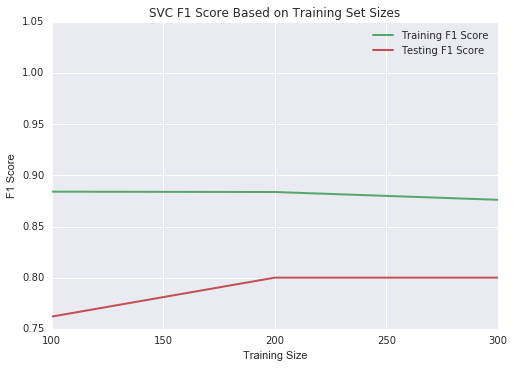

running train_set_sizes(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))
0.793503480278
0.794117647059


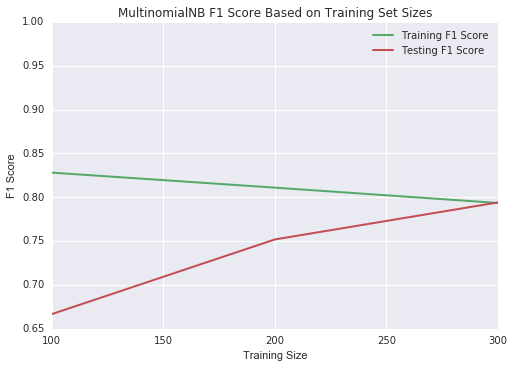

running train_set_sizes(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))
0.844748858447
0.808219178082


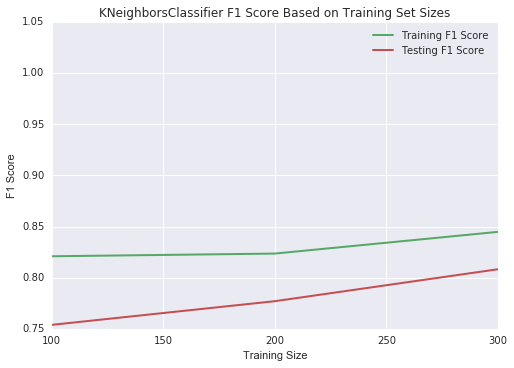

running train_set_sizes(GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))
0.973236009732
0.781954887218


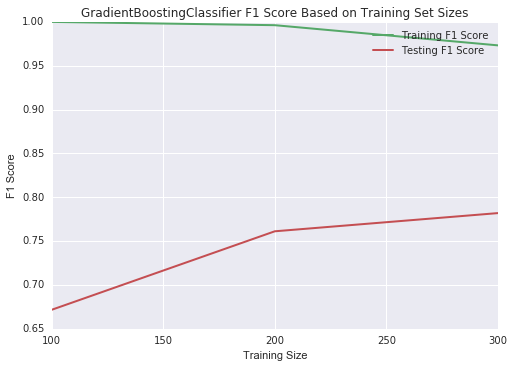

In [46]:
import seaborn as sns

# graphing the training and test F1 scores, based on training size
def performance_metric(true, prediction):
    f1 = f1_score(true, prediction, pos_label='yes')
    
    return f1

def train_set_sizes(clf, X_train, y_train, X_test, y_test):
    train_sizes =[100, 200, 300]
    train_f1 = np.zeros(len(train_sizes))
    test_f1 = np.zeros(len(train_sizes))
    
    for i, s in enumerate(train_sizes):
        clf.fit(X_train[:s], y_train[:s])
        train_f1[i] = performance_metric(y_train[:s], clf.predict(X_train[:s]))
        test_f1[i] = performance_metric(y_test, clf.predict(X_test))
        
    print "running train_set_sizes({})".format(clf)
    
    print train_f1[i]
    print test_f1[i]    
    train_sizes_graph(clf, train_sizes, train_f1, test_f1)


def train_sizes_graph(clf, training_sizes, train_f1, test_f1):
    pl.figure()
    pl.title('{} F1 Score Based on Training Set Sizes'.format(clf.__class__.__name__))
    
    pl.plot(300, 1)
    pl.plot(training_sizes, train_f1, lw=2, label='Training F1 Score')
    pl.plot(training_sizes, test_f1, lw=2, label='Testing F1 Score')
    
    pl.legend()
    pl.xlabel('Training Size')
    pl.ylabel('F1 Score')
    
    pl.show()
    
for clf in classifiers:
    train_set_sizes(clf, X_train, y_train, X_test, y_test)

Training SVC...
Training time (secs): 0.002
Predicting labels using SVC...
Prediction time (secs): 0.002
------------------------------------------
Training set size: 100
Training SVC...
Training time (secs): 0.002
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for training set: 0.884057971014
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for test set: 0.761904761905
Predicting labels using SVC...
Prediction time (secs): 0.002
Predicting labels using SVC...
Prediction time (secs): 0.001
------------------------------------------
Training set size: 100
Training SVC...
Training time (secs): 0.001
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for training set: 0.884057971014
Predicting labels using SVC...
Prediction time (secs): 0.002
F1 score for test set: 0.761904761905
Predicting labels using SVC...
Prediction time (secs): 0.002
Predicting labels using SVC...
Prediction time (secs): 0.001
Training SVC...
Training ti

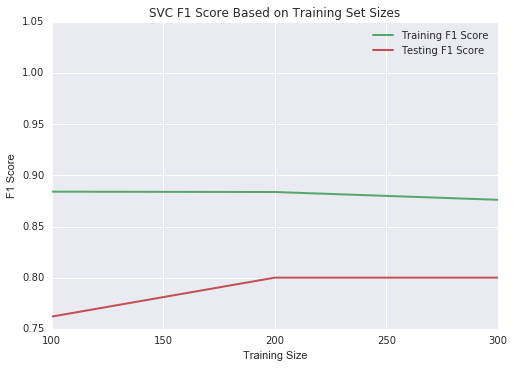

Table for SVC classifier
        100       200       300             Training Sizes
0  0.001742  0.003334  0.009650       Training Time (secs)
1  0.001801  0.004958  0.007256     Prediction Time (secs)
2  0.884058  0.883721  0.876106  F1 score for training set
3  0.761905  0.800000  0.800000      F1 score for test set
0.426323890686 seconds
Training MultinomialNB...
Training time (secs): 0.001
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
------------------------------------------
Training set size: 100
Training MultinomialNB...
Training time (secs): 0.001
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
F1 score for training set: 0.828125
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
F1 score for test set: 0.666666666667
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
Predicting labels using MultinomialNB...
Prediction time (secs): 0.001
------------------------------------------
Training se

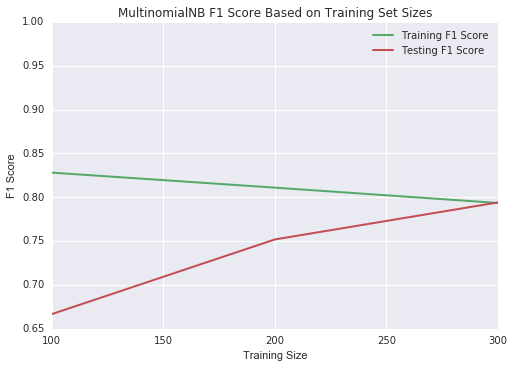

Table for MultinomialNB classifier
        100       200       300             Training Sizes
0  0.001414  0.001239  0.001693       Training Time (secs)
1  0.000908  0.001057  0.001274     Prediction Time (secs)
2  0.828125  0.810997  0.793503  F1 score for training set
3  0.666667  0.751880  0.794118      F1 score for test set
0.336982011795 seconds
Training KNeighborsClassifier...
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Prediction time (secs): 0.003
------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Prediction time (secs): 0.002
F1 score for training set: 0.820895522388
Predicting labels using KNeighborsClassifier...
Prediction time (secs): 0.002
F1 score for test set: 0.753846153846
Predicting labels using KNeighborsClassifier...
Prediction time (secs): 0.003
Predicting labels using KNeighborsClassifier...
Prediction time (se

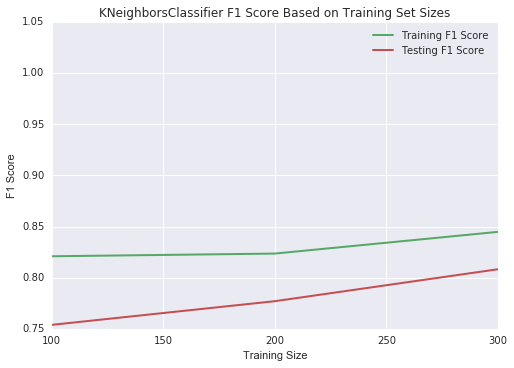

Table for KNeighborsClassifier classifier
        100       200       300             Training Sizes
0  0.001089  0.000717  0.000800       Training Time (secs)
1  0.002669  0.004293  0.008462     Prediction Time (secs)
2  0.820896  0.823529  0.844749  F1 score for training set
3  0.753846  0.776978  0.808219      F1 score for test set
0.429560899734 seconds
Training GradientBoostingClassifier...
Training time (secs): 0.072
Predicting labels using GradientBoostingClassifier...
Prediction time (secs): 0.001
------------------------------------------
Training set size: 100
Training GradientBoostingClassifier...
Training time (secs): 0.073
Predicting labels using GradientBoostingClassifier...
Prediction time (secs): 0.001
F1 score for training set: 1.0
Predicting labels using GradientBoostingClassifier...
Prediction time (secs): 0.001
F1 score for test set: 0.666666666667
Predicting labels using GradientBoostingClassifier...
Prediction time (secs): 0.001
Predicting labels using GradientBoo

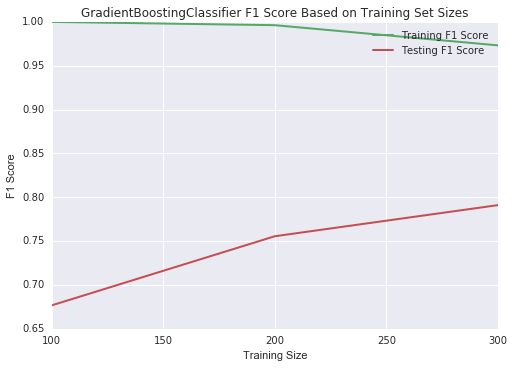

Table for GradientBoostingClassifier classifier
        100       200       300             Training Sizes
0  0.072079  0.077816  0.103385       Training Time (secs)
1  0.001297  0.001633  0.002151     Prediction Time (secs)
2  1.000000  0.992593  0.973236  F1 score for training set
3  0.666667  0.788321  0.781955      F1 score for test set
1.31752085686 seconds


In [47]:
# creates graphs from the supporting functions, above
# also creates a results table for the classifier
def run_model(clf, X_train, y_train, X_test, y_test):
    start = time.time()
    train_sizes = [100, 200, 300]
    table_data = []
    for train_size in train_sizes:
        # fit classifier
        training_time = train_classifier(clf, X_train[:train_size], y_train[:train_size])
        # predict and run the time
        prediction_time = predict_labels(clf, X_train[:train_size], y_train[:train_size])[1]
        # train and get f1 scores
        training_f1 = train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)[0]
        # test and get f1 scores
        test_f1 = train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)[1]
        
        table_data.append([training_time, prediction_time, training_f1, test_f1])
        
    train_set_sizes(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)
    end = time.time()
    
    rows = ['Training Sizes', 'Training Time (secs)', 'Prediction Time (secs)', 'F1 score for training set', 'F1 score for test set']
    d = {'Training Sizes': rows[1:],
         '100': pd.Series(table_data[0]), 
         '200': pd.Series(table_data[1]), 
         '300': pd.Series(table_data[2])}
    table_dataframe = pd.DataFrame(d)
    
    print "Table for {} classifier".format(clf.__class__.__name__)    
    print table_dataframe
    print "{} seconds".format(end - start)
    
for clf in classifiers:
    run_model(clf, X_train, y_train, X_test, y_test)

In [48]:
# optimized F1 score
def optimized_model(X_train, y_train, X_test, y_test):
    # {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'distance', 'algorithm': 'brute'}
    
    clf = neighbors.KNeighborsClassifier(n_neighbors=8, metric='euclidean', weights='distance', algorithm='brute')
    clf.fit(X_train, y_train)
    
    print performance_metric(y_test, clf.predict(X_test))
    
print "Optimized Model's F1 Score: "
optimized_model(X_train, y_train, X_test, y_test)

Optimized Model's F1 Score: 
0.802721088435
